# Preparing Data

## Import Library and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The following describes the dataset columns:

```
crim - per capita crime rate by town
zn - proportion of residential land zoned for lots over 25,000 sq.ft.
indus - proportion of non-retail business acres per town.
chas - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
nox - nitric oxides concentration (parts per 10 million)
rm - average number of rooms per dwelling
age - proportion of owner-occupied units built prior to 1940
dis - weighted distances to five Boston employment centres
rad - index of accessibility to radial highways
tax - full-value property-tax rate per $10,000
ptratio - pupil-teacher ratio by town
black - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
lstat - % lower status of the population
medv - Median value of owner-occupied homes in $1000's
```



In [ ]:
df = pd.read_csv('boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


## Pre Processing Data

In [ ]:
# Duplicate value
print(f'Total duplicate value: {df.duplicated().sum()}')

Total duplicate value: 0


In [ ]:
# Invalid and missing values
missing_df = pd.DataFrame({'Data Type': df.dtypes, 'Missing Count': df.isnull().sum(), 'Missing Percentage': (df.isnull().sum() / len(df)) * 100}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] != 0]
missing_df = missing_df.style.format({'Missing Percentage': '{:.2f}%'})
display(missing_df)

,Data Type,Missing Count,Missing Percentage


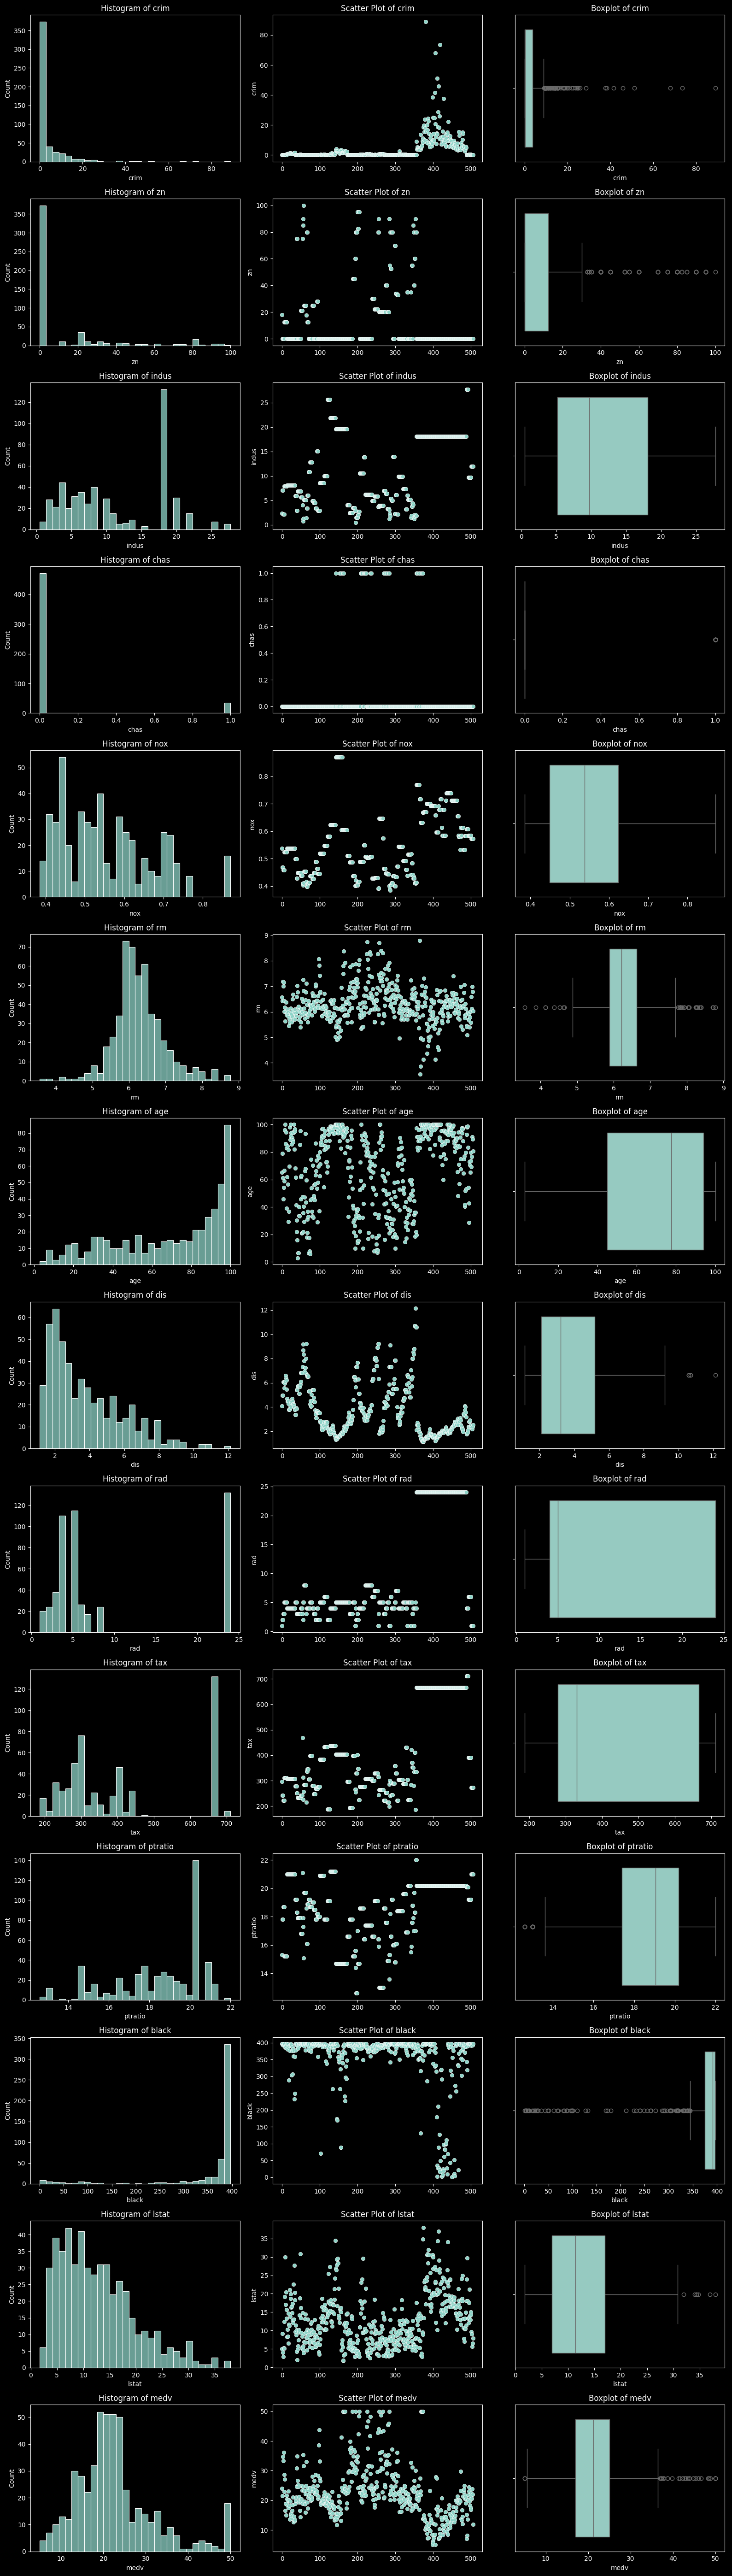

In [ ]:
# Outlier

def distribution_plot(data, variable):
  fig, axes = plt.subplots(nrows=len(variable), ncols=3, figsize=(16,4*len(variable)))
  plt.style.use('dark_background')
  for i in range(0, len(variable)):
    # Histogram
    sns.histplot(data[variable[i]], bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Histogram of {variable[i]}")
    # Sctter plot
    sns.scatterplot(x=range(len(data[variable[i]])), y=data[variable[i]], ax=axes[i, 1])
    axes[i, 1].set_title(f"Scatter Plot of {variable[i]}")
    # Box plot
    sns.boxplot(data[variable[i]], orient='h', ax=axes[i, 2])
    axes[i, 2].set_title(f"Boxplot of {variable[i]}")
  plt.tight_layout()
  plt.show()

variable = df.select_dtypes(include='number').columns
distribution_plot(df, variable)

In [ ]:
# Handling missing value
df = df[~(df['crim'] > 10)]
df = df[~(df['black'] < 360)]

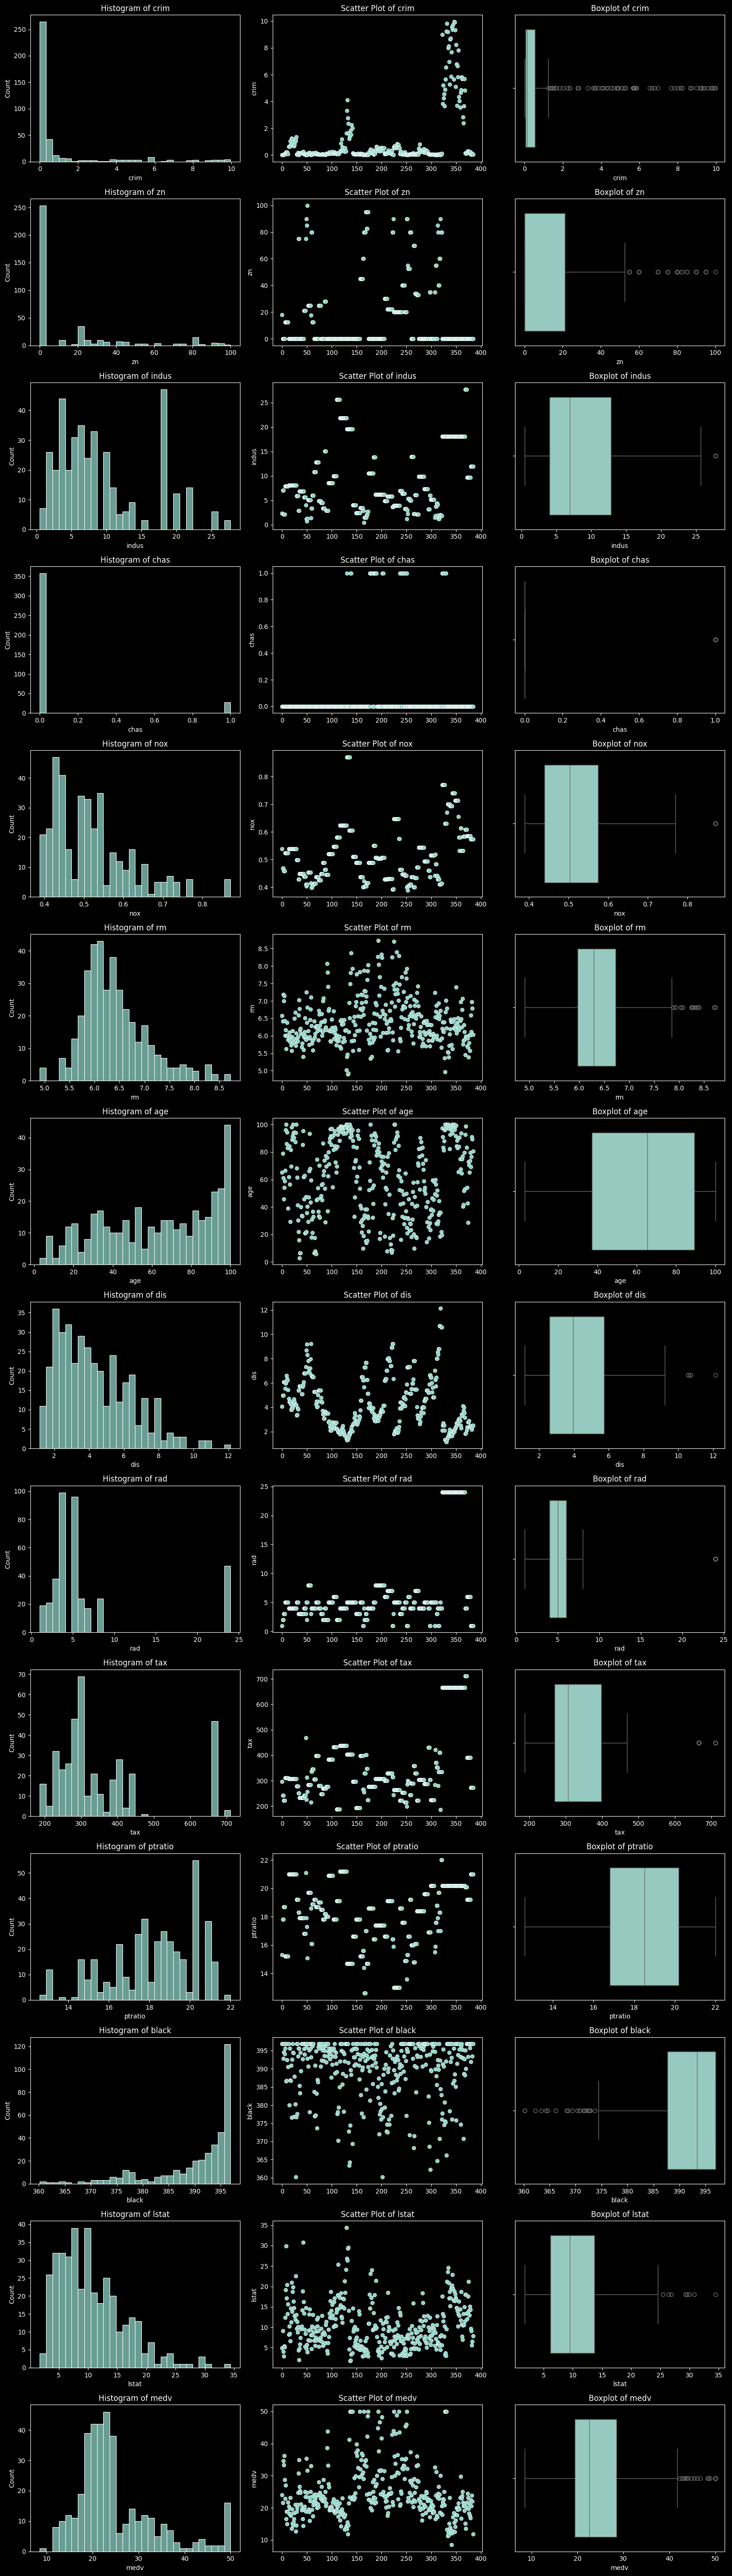

In [ ]:
# Check distribution after handling
distribution_plot(df, variable)

In [ ]:
df.shape

(385, 14)

## Split Data: train-validation-test

In [ ]:
# Split train test
from sklearn.model_selection import train_test_split

X = df.drop(columns='medv')
y = df[['medv']]

# First splitting: pretrain and test
X_pretrain, X_test, y_pretrain, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Second splitting: train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X_pretrain, y_pretrain, test_size=0.20, random_state=42)

## Multicollinear Check

In [ ]:
# Calculating VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,crim,6.664521
2,zn,2.863255
3,indus,3.939494
4,chas,1.092535
5,nox,4.824774
6,rm,2.515112
7,age,3.028267
8,dis,4.066769
9,rad,8.576188
10,tax,6.829713


There are several features with high VIF scores:
1.   crim (moderate multicollinearity)
2.   nox (moderate multicollinearity)
3.   dis (moderate multicollinearity)
4.   rad (moderate multicollinearity)
5.   tax (moderate multicollinearity)

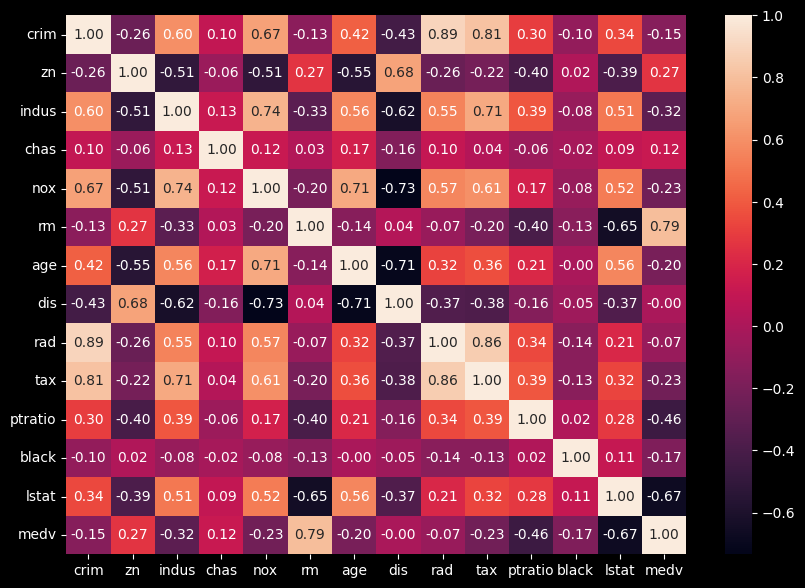

In [ ]:
# Heatmap correlation
df_train = pd.concat([X_train, y_train], axis=1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
plt.style.use('dark_background')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

The features with very strong correlation (>= 0.80): crim-rad (0.89), crim-tax (0.81), and rad-tax (0.86). Therefore, we need to retain one of them, specifically the one with the highest correlation to the target variable.
*   retain tax
*   drop crim and rad


`Note`: Although the variables nox and dis have VIF scores greater than 4, their correlation with other variables is not considered very high/strong. Therefore, in this case, it is not necessary to drop either or both of these variables.

In [ ]:
# Drop crim and rad columns
X_train = X_train.drop(columns=['crim', 'rad'])
X_validation = X_validation.drop(columns=['crim', 'rad'])
X_test = X_test.drop(columns=['crim', 'rad'])

In [ ]:
# Calculating VIF scores after drop
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(X_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature', 'vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,zn,2.633743
2,indus,3.627432
3,chas,1.055247
4,nox,4.184667
5,rm,2.453733
6,age,3.006814
7,dis,4.051415
8,tax,2.633355
9,ptratio,1.737344
10,black,1.127749


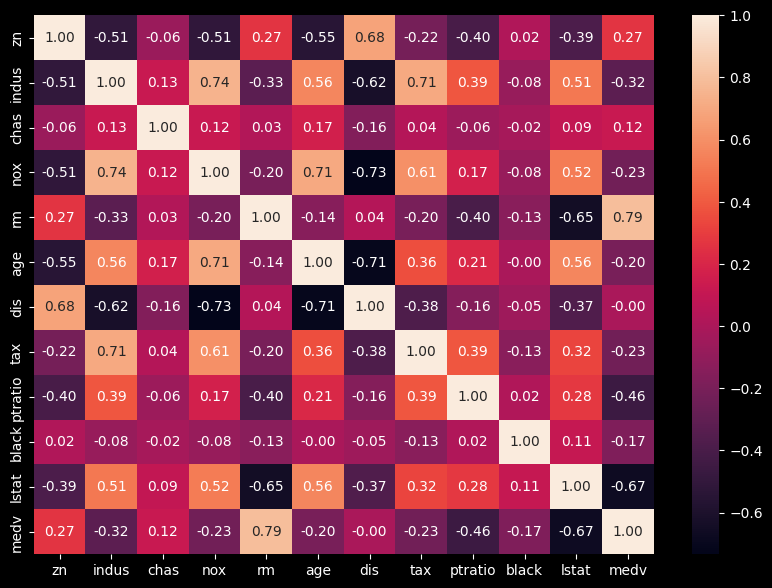

In [ ]:
# Heatmap correlation after drop
df_train = pd.concat([X_train, y_train], axis=1)
corr = df_train.corr()

plt.figure(figsize=(10,7))
plt.style.use('dark_background')
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

# Best Param & Features

## Ridge Regression

### Train Model

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling X
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_validation_std = scaler.transform(X_validation)
X_test_std = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Tuning alpha using Grid Search
alpha_values = np.arange(0.01, 10, 0.01)
ridge_cv = GridSearchCV(Ridge(random_state=42), param_grid={'alpha': alpha_values}, cv=5, scoring='neg_root_mean_squared_error')

# Train model
ridge_cv.fit(X_train_std, y_train.to_numpy())

# Best Model
print(f"The minimum RMSE is {-ridge_cv.cv_results_['mean_test_score'][ridge_cv.best_index_]:.6f} with the alpha = {ridge_cv.best_params_['alpha']:.2f} -> The best model")

The minimum RMSE is 4.898989 with the alpha = 9.99 -> The best model


### Coefficients

#### Interpretation

In [ ]:
# Convert scaled beta to original beta
coef_ridge_unscaled = ridge_cv.best_estimator_.coef_ / scaler.scale_
intercept_ridge_unscaled = ridge_cv.best_estimator_.intercept_ - np.sum(coef_ridge_unscaled * scaler.mean_)

# Create a temporary DataFrame without the 'stability_status'
coef_ridge_temp = pd.DataFrame({
    'feature': ['intercept'] + X_train.columns.tolist(),
    'coef_final': [intercept_ridge_unscaled[0]] + list(coef_ridge_unscaled),
    'coef_std': [ridge_cv.best_estimator_.intercept_[0]] + list(ridge_cv.best_estimator_.coef_)})
coef_ridge_temp

,feature,coef_final,coef_std
0,intercept,58.944911,25.051626
1,zn,0.036842,0.977549
2,indus,-0.037299,-0.231747
3,chas,3.240922,0.924845
4,nox,-10.394733,-1.064678
5,rm,5.825036,3.859131
6,age,-0.004483,-0.127601
7,dis,-1.350825,-2.956714
8,tax,0.000287,0.039822
9,ptratio,-0.660242,-1.392666


**Standardized Coefficients (coef_std):**

Standardized coefficients (coef_std) help compare how different features affect changes in the median value of homes. Because the values have already been standardized, direct comparisons are valid. The smaller the absolute coefficient, the less impact the feature has on changes in the median home value.

**The established model:**


```
medv = 58.944911 + 0.036842*zn - 0.037299*indus + 3.240922*chas - ... - 0.522423*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   A high percentage of land used for non-retail industrial businesses.
 *   High levels of nitric oxides (gases usually produced from combustion processes, such as vehicle engines, power plants, or industrial activities).
 *   A high proportion of older homes (built before 1940).
 *   Long distances between homes and the five Boston employment centers.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high proportion of Black residents.
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   Homes bordering the Charles River.
 *   Homes with a greater number of rooms.
 *   High property tax rates.


**Interpretation of some variable and its impact:**
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.036842 thousand dollar.
*   Homes bordering the Charles River (chas = 1) have a median value of homes (medv) that is 3.240922 thousand dollar higher compared to homes that do not border the Charles River (chas = 0).
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.522423 thousand dollar.
*   etc.

#### Evaluation

In this study, bootstrap sampling was used alongside Ridge Regression to assess the stability and reliability of coefficient estimates. While Ridge reduces overfitting and handles multicollinearity, it does not naturally provide uncertainty estimates. By fitting the Ridge model on multiple bootstrap samples, we obtained distributions of each coefficient, allowing us to compute their mean, standard deviation, and confidence intervals. This helps identify which features have consistently strong effects and which ones are unstable or not significant. The combination of Ridge and bootstrap offers more robust and interpretable results.

In [ ]:
# Bootstrap processing
np.random.seed(42)
n_bootstrap = 1000
alpha_ridge = ridge_cv.best_params_['alpha']

coefs = []
for _ in range(n_bootstrap):
    idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    X_boot = X_train_std[idx]
    y_boot = y_train.values[idx]
    model = Ridge(alpha=alpha_ridge)
    model.fit(X_boot, y_boot)
    coefs.append(model.coef_)
coefs = np.array(coefs)

ridge_bootstrap_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef_mean': coefs.mean(axis=0),
    'std_dev': coefs.std(axis=0),
    '95% CI lower': np.percentile(coefs, 2.5, axis=0),
    '95% CI upper': np.percentile(coefs, 97.5, axis=0)})
ridge_bootstrap_df['ci_width'] = ridge_bootstrap_df['95% CI upper'] - ridge_bootstrap_df['95% CI lower']
ridge_bootstrap_df['ci_includes_zero'] = (ridge_bootstrap_df['95% CI lower'] < 0) & (ridge_bootstrap_df['95% CI upper'] > 0)
ridge_bootstrap_df['ci_includes_zero'] = ridge_bootstrap_df['ci_includes_zero'].apply(lambda x: '❌' if x else '✅')

In [ ]:
# Merge tables
coef_ridge_df = coef_ridge_temp.merge(ridge_bootstrap_df[['feature', 'coef_mean', 'ci_width', 'ci_includes_zero']], on='feature', how='left')

# Determining label features
def label_feature(row, threshold_ci_width=2.0, threshold_diff=1.0):
    ci_includes_zero = row['ci_includes_zero']
    coef_diff = abs(row['coef_mean'] - row['coef_std'])
    ci_width = row['ci_width']

    if (ci_includes_zero == '✅' and coef_diff <= threshold_diff and ci_width <= threshold_ci_width): return "✅ Stable & Significant"
    elif coef_diff <= threshold_diff and ci_width > threshold_ci_width: return "❓ Possibly Important but Uncertain"
    elif ci_includes_zero: return "❌ Not Significant"
    else: return "⚠️ Unstable"

# Apply to table
coef_ridge_df['label_feature'] = coef_ridge_df.apply(label_feature, axis=1)
coef_ridge_df.drop(index=0)

,feature,coef_final,coef_std,coef_mean,ci_width,ci_includes_zero,label_feature
1,zn,0.036842,0.977549,0.931003,1.727197,✅,✅ Stable & Significant
2,indus,-0.037299,-0.231747,-0.236911,1.377627,❌,❌ Not Significant
3,chas,3.240922,0.924845,0.919754,1.503631,✅,✅ Stable & Significant
4,nox,-10.394733,-1.064678,-0.975088,1.975458,✅,✅ Stable & Significant
5,rm,5.825036,3.859131,3.979018,3.350912,✅,❓ Possibly Important but Uncertain
6,age,-0.004483,-0.127601,-0.242148,2.255493,❌,❓ Possibly Important but Uncertain
7,dis,-1.350825,-2.956714,-2.877224,2.448887,✅,❓ Possibly Important but Uncertain
8,tax,0.000287,0.039822,-0.022143,1.906675,❌,❌ Not Significant
9,ptratio,-0.660242,-1.392666,-1.378979,1.164365,✅,✅ Stable & Significant
10,black,-0.109269,-0.892062,-0.868980,1.685906,✅,✅ Stable & Significant


**Label Description**


| Label | Description | Criteria |
|-------|-------------|----------|
| ✅ **Stable & Significant** | Coefficient is stable, significant, and can be interpreted with high confidence. | CI does **not** cross zero, **narrow CI**, and `coef_final ≈ coef_mean` |
| ❓ **Possibly Important but Uncertain** | Coefficient is relatively consistent, but the model is not confident enough. Interpret with caution. | `coef_final ≈ coef_mean`, but **CI is wide** or **crosses zero** |
| ⚠️ **Unstable** | Model is not consistent in estimating this feature’s effect. It varies across bootstrap samples. | `coef_final ≠ coef_mean` or **CI is very wide** |
| ❌ **Not Significant** | Coefficient is not significant. Effect is unclear or negligible. | **CI crosses zero**, no strong or consistent effect |

- `Significant coefficient`: means its confidence interval does not include zero, suggesting a consistent effect on the target variable.
- `Stable coefficient`: shows little variation across bootstrap samples, typically indicated by a narrow confidence interval and `coef_final ≈ coef_mean`

📌 Summary Based on Bootstrap Ridge Coefficient Analysis:
From the analysis of 12 features using Ridge regression and bootstrap sampling:

- 5 features were labeled as ✅ Stable & Significant (zn, chas, nox, ptratio, black), meaning their estimated effects were consistent and statistically reliable.

- 4 features (rm, age, dis, lstat) fell under ❓ Possibly Important but Uncertain. While their coefficients were large and consistent with the bootstrap mean, the wide confidence intervals suggested less certainty in interpretation.

- 0 features were flagged as ⚠️ Unstable, indicating good consistency across the model.

- 2 features (indus, tax) were ❌ Not Significant, as their confidence intervals included zero, suggesting unclear or weak effects.

This labeling helps identify which predictors are robust and interpretable, and which should be treated with caution or excluded from interpretation due to low reliability.

## LASSO Regression

### Train Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Tuning alpha using Grid Search
alpha_values = np.arange(0.01, 10, 0.01)
lasso_cv = GridSearchCV(Lasso(random_state=42), param_grid={'alpha': alpha_values}, cv=5, scoring='neg_root_mean_squared_error')

# Train model
lasso_cv.fit(X_train_std, y_train.to_numpy())

# Best Model
print(f"The minimum RMSE is {-lasso_cv.cv_results_['mean_test_score'][lasso_cv.best_index_]:.6f} with the alpha = {lasso_cv.best_params_['alpha']:.2f} -> The best model")

The minimum RMSE is 4.927752 with the alpha = 0.09 -> The best model


### Coefficients

#### Interpretation

In [ ]:
# Convert scaled beta to original beta
coef_lasso_unscaled = lasso_cv.best_estimator_.coef_ / scaler.scale_
intercept_lasso_unscaled = lasso_cv.best_estimator_.intercept_ - np.sum(coef_lasso_unscaled * scaler.mean_)

coef_lasso_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coef_final': [intercept_lasso_unscaled[0]] + list(coef_lasso_unscaled),
    'coef_std':[lasso_cv.best_estimator_.intercept_[0]] + list(lasso_cv.best_estimator_.coef_)})
coef_lasso_df

,feature,coef_final,coef_std
0,intercept,52.007906,25.051626
1,zn,0.033727,0.894894
2,indus,-0.004331,-0.026911
3,chas,3.009818,0.858896
4,nox,-10.180347,-1.042719
5,rm,6.008899,3.980941
6,age,-0.000000,-0.000000
7,dis,-1.258448,-2.754517
8,tax,-0.000000,-0.000000
9,ptratio,-0.657829,-1.387576


**Notes**

The variables age and tax have coefficients of 0. This means that these variables are considered to have no significant influence on the median value of homes (medv) and, therefore, are excluded from the model. We will see how much these variables contribute to the target variable in the evaluation chapter.


**The established model:**


```
medv = 52.007906 + 0.033727*zn - 0.004331*indus + 3.009818*chas - ... - 0.538226*lstat
```

**Based on the equations above, we can conclude two points:**
1.   There are several factors that contribute to a decline in the median value of homes (medv), including:
 *   A high percentage of land used for non-retail industrial businesses.
 *   High levels of nitric oxides (gases usually produced from combustion processes, such as vehicle engines, power plants, or industrial activities).
 *   Long distances between homes and the five Boston employment centers.
 *   An imbalanced pupil-teacher ratio (more pupils than teachers).
 *   Homes located in areas with a high proportion of Black residents.
 *   Homes located in areas with a high percentage of the population with low socio-economic status.
2.   Factors contributing to an increase in the median value of homes (medv) include:
 *   A higher percentage of land allocated for residential zones, indicating that the home is located in a neighborhood with many residential areas.
 *   Homes bordering the Charles River.
 *   Homes with a greater number of rooms.

**Interpretation of each variable and its impact:**
*   Every increase of 1 unit in the proportion of residential land zoned (zn) increases the median value of homes (medv) by 0.033727 thousand dollar.
*   Every increase of 1 unit in the percentage of the population with low socio-economic status (lstat) decreases the median value of homes (medv) by 0.538226 thousand dollar.
*   etc.

#### Evaluation

In [ ]:
from sklearn.utils import resample

# Apply Bootstrap Sampling with Best Alpha
n_bootstraps = 1000
feature_counts = np.zeros(X_train_std.shape[1])
for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_train_std, y_train, replace=True)
    lasso = Lasso(alpha = lasso_cv.best_params_['alpha'])
    lasso.fit(X_sample, y_sample)
    feature_counts += (lasso.coef_ != 0)

feature_stability = pd.DataFrame({
    'Feature': X_train.columns,
    'Selection Frequency (%)': (feature_counts / n_bootstraps) * 100})

feature_stability.sort_values(by='Selection Frequency (%)', ascending=False)

,Feature,Selection Frequency (%)
8,ptratio,100.0
6,dis,100.0
4,rm,100.0
10,lstat,99.5
2,chas,99.1
9,black,95.9
0,zn,94.3
3,nox,92.7
5,age,72.6
7,tax,66.9


Insight 💡
- Based on the bootstrap results, several features were selected consistently across all samples, with `ptratio, dis, rm` appearing in 100% of iterations. This indicates they are the most stable and influential predictors in the model.
- Features like `lstat, chas, black, zn, and nox` also showed high selection frequencies (> 80%), suggesting potential importance with slightly less consistency.
- Meanwhile, variables such as `age, tax, and indus` had lower frequencies (< 75%), implying they may have weaker or less stable contributions. This is consistent with the feature selection performed by LASSO without bootstrapping, where all three variables have a coefficient of 0 or ≈0.

Attention ⚠️
- Although `indus` was retained in the final LASSO model with a small non-zero coefficient (~0.004), its low selection frequency across bootstrap samples (55.9%) suggests instability and limited importance.
- In contrast, two other features (`age, tax`), which were excluded by the final model (coefficient = 0), demonstrated higher selection frequencies (72.6% and 66.9%, respectively). This indicates that while these features were not selected in the final fit, they may still hold predictive value and warrant further consideration.

Overall, the bootstrap selection frequencies help identify features with strong and reliable predictive power.

# Diagnostic Study

## Ridge Regression

### R-Square

In [ ]:
from sklearn.metrics import r2_score

y_predict_train_ridge = ridge_cv.predict(X_train_std)
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train_ridge)))

R-squared for training data is 0.7532189248565029


The R-Square value in the Ridge Regression is `0.7532189248565029` or approximately `75.32%`. This indicates that the twelve independent variables/features included in the model are able to explain `75.32%` of the variability in the dependent variable (medv/median value of homes). The remaining `24.68%` is explained by other variables outside the model.

### Assumption Check

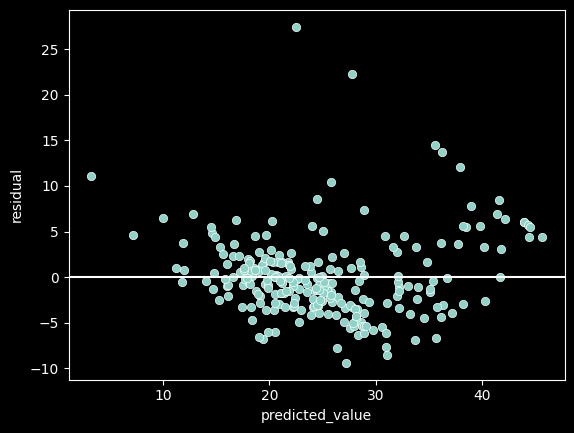

In [ ]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train_ridge

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_ridge,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Fulfilled. The horizontal line at y=0 adequately represents the overall distribution of residual points.
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [ ]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train_ridge = ridge_cv.predict(X_train_std)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train_ridge))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train_ridge)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train_ridge)))

RMSE for training data is 4.465904064150407
MAE for training data is 3.1197751440034835
MAPE for training data is 0.12609980171208493


In [ ]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test_ridge = ridge_cv.predict(X_test_std)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test_ridge))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test_ridge)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test_ridge)))

RMSE for testing data is 3.2351404626518168
MAE for testing data is 2.4242470985103943
MAPE for testing data is 0.10627789579691696


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences (only slightly lower), suggesting that the selected model has been proven to be well-suited.

## LASSO Regression

### R-Square

In [ ]:
from sklearn.metrics import r2_score

y_predict_train_lasso = lasso_cv.predict(X_train_std)
print('R-squared for training data is {}'.format(r2_score(y_train.to_numpy(), y_predict_train_lasso)))

R-squared for training data is 0.7525031291642488


The R-Square value in the LASSO Regression is `0.7525031291642488` or approximately `75.25%`. This indicates that the nine independent variables/features included in the model are able to explain `75.25%` of the variability in the dependent variable (medv/median value of homes). The remaining `24.75%` is explained by other variables outside the model.

### Assumption Check

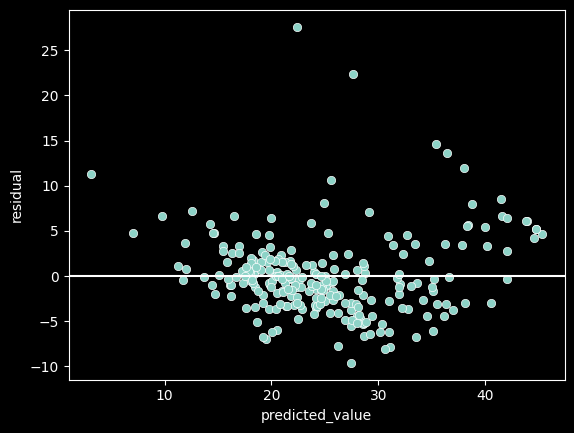

In [ ]:
# Calculate residuals
residual = y_train.to_numpy()[:, 0] - y_predict_train_lasso

# Prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train_lasso,
    'residual': residual})

# Residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption Checks:
*   Linear relationship: Not fulfilled. The residual points are not evenly distributed around the y=0 line (more data below the y=0 line).
*   Variance stability: Not fulfilled. Variance is more pronounced at the beginning and end of the data.
*   Independent residuals: Not fulfilled. The residual points appear to form a curved (non-linear) pattern.

### Model Evaluation

In [ ]:
# Calculating error of Data Training

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on train data
y_predict_train_lasso = lasso_cv.predict(X_train_std)

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train.to_numpy(), y_predict_train_lasso))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train.to_numpy(), y_predict_train_lasso)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train.to_numpy(), y_predict_train_lasso)))

RMSE for training data is 4.472376116824596
MAE for training data is 3.1181839016085973
MAPE for training data is 0.1264419045104829


In [ ]:
# Calculating error of Data Testing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Prepare prediction result on test data
y_predict_test_lasso = lasso_cv.predict(X_test_std)

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_test.to_numpy(), y_predict_test_lasso))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_test.to_numpy(), y_predict_test_lasso)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_test.to_numpy(), y_predict_test_lasso)))

RMSE for testing data is 3.1857340511563015
MAE for testing data is 2.392750397658332
MAPE for testing data is 0.10587429658760313


The evaluation results of the model indicate that the RMSE, MAE, and MAPE values for the training data and testing data do not show significant differences, and are even lower for the testing data, suggesting that the selected model has been proven to be well-suited.

# Conclusion

## Summary

| Model  | Dataset | R²     | RMSE | MAE  | MAPE |
|--------|---------|--------|------|------|------|
| Ridge  | Train   | 75.32% | 4.47 | 3.12 | 0.13 |
| Ridge  | Test    | –      | 3.23 | 2.42 | 0.11 |
| LASSO  | Train   | 75.25% | 4.47 | 3.12 | 0.13 |
| LASSO  | Test    | –      | 3.19 | 2.39 | 0.11 |

| Metric     | Ridge (Test) | LASSO (Test) | Best     |
|------------|--------------|--------------|----------|
| R²         | 75.32%       | 75.25%       | ✅ Ridge |
| RMSE       | 3.23         | 3.19         | ✅ LASSO |
| MAE        | 2.42         | 2.39         | ✅ LASSO |
| MAPE       | 0.11         | 0.11         | Balanced  |

Both Ridge and LASSO models show comparable performance with similar R² values (~75%) and error metrics. LASSO slightly outperforms Ridge on the test set in terms of RMSE and MAE, while both models yield identical MAPE. Overall, LASSO demonstrates a marginal advantage in predictive accuracy, although Ridge remains a competitive alternative.

## Research Recommendation

**📌 Recommendations from a Research Perspective**

1. **Prioritize Stable & Significant Predictors in Modeling**  
   Variables such as `ptratio, dis, rm, lstat, chas, black, zn, nox` were found to be statistically significant and stable across bootstrap samples. These features consistently influenced the target variable (`medv`) with narrow confidence intervals and minimal coefficient variability.  
   ➤ *Recommendation:* Future regression models or predictive frameworks should prioritize these features for improved accuracy and interpretability.

2. **Deprioritize Non-Significant Variables**  
   Variables such as `age, tax, indus` had lower selection frequencies in bootstrap (< 75%), implying they may have weaker or less stable contributions. This is consistent with the feature selection performed by LASSO without bootstrapping, where all three variables have a coefficient of 0 or ≈0.  
   ➤ *Recommendation:* Consider removing or regularizing these variables more strongly in future models to reduce complexity without sacrificing performance.

3. **Use Bootstrap as a Robust Complement to Traditional Inference**  
   The bootstrap approach provided valuable insights into coefficient variability and model stability that traditional single-sample estimations cannot.  
   ➤ *Recommendation:* Researchers should adopt bootstrap-based inference (e.g., CI estimation, selection frequency) as part of regular regression diagnostics, especially when working with penalized models like Ridge or Lasso.

4. **Bridge Statistical and Substantive Relevance**  
   While statistical significance is critical, aligning it with domain knowledge (e.g., real estate valuation) enhances the practical relevance of findings. For example, although `tax` was statistically insignificant, its real-world policy implications may still justify further exploration.  
   ➤ *Recommendation:* Combine statistical metrics with theory-driven justifications when deciding on final model features.

## Business Recommendation

**💼 Business Recommendations Based on LASSO Bootstrap Analysis**

1. **Focus Urban Planning on Environmental and Educational Quality**  
   Features like **nox (air pollution)** and **ptratio (pupil-teacher ratio)** were found to have strong, consistent negative impacts on housing prices.  
   ➤ *Action:* Policymakers and urban developers should invest in cleaner environments and better education systems to support higher property values.

2. **Promote Housing Near Employment Centers**  
   The variable **dis (distance to employment centers)** showed a stable negative relationship with home prices, indicating that proximity to jobs remains a key value driver.  
   ➤ *Action:* Encourage housing development near business districts and improve transportation to reduce commuting times.

3. **Preserve and Leverage Natural Amenities**  
   The **chas** variable (whether a property is near the Charles River) was a strong positive predictor of value.  
   ➤ *Action:* Maintain and market natural or scenic features like rivers and parks to increase real estate desirability.

4. **Highlight Home Quality in Marketing**  
   Although **rm (average number of rooms)** showed some uncertainty, its consistent positive impact suggests that larger homes are generally more valued.  
   ➤ *Action:* Emphasize spaciousness and home upgrades in property listings and renovations.

5. **Be Cautious with Taxes in Messaging**  
   Variables like **tax** was not consistently significant in the model, suggesting their impact may be nuanced or dependent on other factors.  
   ➤ *Action:* Don’t overemphasize tax rates in pricing strategy—focus instead on holistic neighborhood benefits.

6. **Use Data-Driven Insights in Real Estate Strategy**  
   The combination of Ridge regression with bootstrap analysis provides a more reliable view of what drives housing prices.  
   ➤ *Action:* Real estate professionals and investors should leverage such robust statistical techniques to guide investment decisions and market analysis.